<a href="https://colab.research.google.com/github/leonbenenati/Leon_Lighthouse/blob/main/Leon_Lighthouse_Predicao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem

Para criar um modelo para prever o salário será utilizado a base de treino dividindo ela em treino em teste para evitar vazamento de dados

A váriavel de interesse é a yearly_wage, ela apresenta dois valores, se a pessoa ganha mais ou menos de 50 mil, será transformada para 0 se ganha menos de 50 mil 1 se ganha mais

Como a váriavel de interesse assume a forma de 0 e 1 para a previsão estamos num problema de classificação 

Será utilizado o modelo LightGBM é um modelo do tipo árvore, que não requer tanta preparação nos dados, não sofre com as escalas das variáveis númericas e é rápido 

Será testado 3 preparação de dados, a base e mais duas


*   Modelagem base: Será criada Dummy nas variaveis categóricas, será dropada uma pois não é necessário, onde se todas as dummy forem 0 é necessariamente a outra que foi dropada. A váriavel native_country sofrerá modificações, como há muitos países e estes são númerosos será somados menos o EUA, depois da transformação terá dois valores, se a pessoa é do EUA ou não.

*   Na seguda preparação de dados a education	será dropada, pois há a education_num que é a representação númerica da education, e há a vantagem de ser apenas uma columa, enquanto que a education precisa ser dummyficada gerando várias colunas que talvez sejam desnecessárias

*   Na terceira modelagem será utilizado a que teve a melhor perfomace, a base ou a segunda. Com a EDA percebi que capital_gain	e capital_loss tem 0 e outros números maiores que zero, nessas duas depois da transformação o 0 será 0 e números maiores que 0 serão 1, será uma dummy, se o que importá nesse váriável for o fato de ter ganho ou perda de capital não afetará o modelo, se o valor for importante a perfomace será impactada 


Curva ROC: A metríca escolhida foi a AUC/Curva Roc pois com ela podemos ver o gráfico de taxa de verdadeiros positivos e taxa falsos positivos e ela traça esse gráfico em diferentes limiares, e para a comparação há a área sobre a curva, que varia de 0 a 1

A melhor preparação será usada para previsão na base teste 






# Preparação inicial

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/wage_train.csv")
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_wage
0,0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [ ]:
df['yearly_wage'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [ ]:
df['yearly_wage'] = df['yearly_wage'].map({' <=50K':0, ' >50K':1})
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_wage
0,0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


In [ ]:
df['yearly_wage'].value_counts()/df['yearly_wage'].shape[0]

0    0.759183
1    0.240817
Name: yearly_wage, dtype: float64

In [ ]:
df.drop(['Unnamed: 0','fnlwgt'], axis = 1, inplace = True)
df.head()


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_wage
0,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


In [ ]:
df.isnull().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
yearly_wage       0
dtype: int64

# Modelo base

In [ ]:
X = df.drop('yearly_wage', axis = 1)
y = df['yearly_wage']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=30)

In [ ]:
def auxiliar(x):
    if x ==' United-States':
        return 'eua'
    else:
        return 'não_eua'

X_train['native_country'] = X_train['native_country'].apply(auxiliar)
X_train.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
9476,19,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,40,eua
16917,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,não_eua
31077,18,Private,Some-college,10,Never-married,Tech-support,Own-child,White,Male,2176,0,20,eua
14943,35,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,eua
2658,26,Federal-gov,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,não_eua


In [ ]:
X_test['native_country'] = X_test['native_country'].apply(auxiliar)

In [ ]:
variaveis_cat = ['workclass', 'education', 'marital_status', 'occupation', 'relationship','race','sex','native_country']
X_train_d = pd.get_dummies(X_train,columns=variaveis_cat, drop_first=True)
X_test_d = pd.get_dummies(X_test,columns=variaveis_cat, drop_first=True)
X_train_d

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_não_eua
9476,19,10,0,0,40,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
16917,37,14,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
31077,18,10,2176,0,20,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
14943,35,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2658,26,15,0,0,60,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,62,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
12077,25,9,0,0,40,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
15277,44,10,5178,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4517,61,9,0,0,45,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
X_test_d

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_não_eua
22576,45,9,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
7202,40,15,0,0,55,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4900,45,13,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
7753,18,7,0,0,8,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
1208,36,9,0,0,45,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,26,6,0,0,32,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9252,45,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
15936,34,9,0,0,42,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
5302,19,10,0,0,40,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
# Configuração da Validação
from sklearn.model_selection import RepeatedStratifiedKFold
kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {
    'max_depth': [3,5,7,9,11],
    'n_estimators':[50,100,150,200],
    'learning_rate': [0.05,0.1,0.2],
    'reg_alpha': [0,0.1,0.5],
    'reg_lambda': [0,0.1,0.5],
}
modelo=LGBMClassifier()
lgbm=RandomizedSearchCV(modelo, param_distributions = params,
                                   scoring = 'roc_auc', 
                                   cv = kf, 
                                   verbose = 1,
                                   n_iter = 10,
                                   n_jobs = -1)
lgbm.fit(X_train_d,y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=None),
                   estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [50, 100, 150, 200],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5]},
                   scoring='roc_auc', verbose=1)

In [ ]:
lgbm.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 150,
 'reg_alpha': 0.5,
 'reg_lambda': 0}

In [ ]:
from sklearn.metrics import roc_auc_score

preds = lgbm.predict_proba(X_test_d)[:,1]
roc_auc_score(y_test,preds)

0.9282693875919319

In [ ]:
roc_auc_score(y_test,preds)

0.9282693875919319





*   Score de 0.9282 no teste 







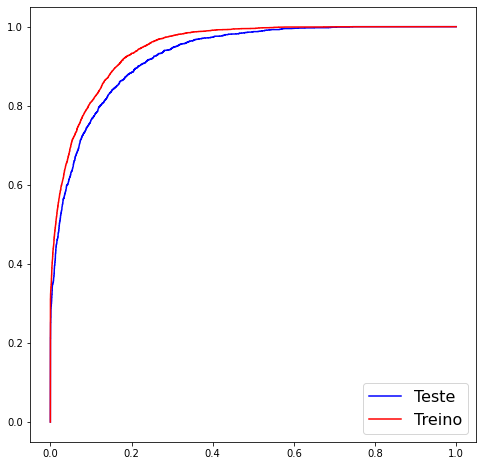

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

fpr,tpr,ths = roc_curve(y_test,preds)
plt.plot(fpr,tpr,color='b', label='Teste')

fpr2,tpr2,ths2 = roc_curve(y_train,lgbm.predict_proba(X_train_d)[:,1])
plt.plot(fpr2,tpr2,color='r', label='Treino')

plt.legend(fontsize=16)





*   AS curva ROC de teste e treino andam praticamente juntas, mas teste está abaixo do treino  





In [ ]:
imps = lgbm.best_estimator_.feature_importances_
cols = X_train_d.columns
order= np.argsort(imps)[::-1]

for col,imp in zip(cols[order],imps[order]):
    print(f'{col:30s} {imp:.2f}')

age                            1001.00
hours_per_week                 615.00
capital_gain                   420.00
education_num                  405.00
capital_loss                   346.00
sex_ Male                      82.00
relationship_ Wife             80.00
marital_status_ Married-civ-spouse 75.00
occupation_ Prof-specialty     73.00
occupation_ Exec-managerial    69.00
workclass_ Self-emp-not-inc    68.00
workclass_ Private             68.00
occupation_ Sales              49.00
workclass_ Local-gov           43.00
education_ Some-college        38.00
workclass_ Federal-gov         37.00
education_ HS-grad             37.00
relationship_ Not-in-family    36.00
marital_status_ Never-married  34.00
occupation_ Farming-fishing    32.00
occupation_ Other-service      31.00
native_country_não_eua         31.00
occupation_ Tech-support       30.00
occupation_ Adm-clerical       30.00
race_ White                    28.00
education_ Bachelors           28.00
relationship_ Unmarried     







*   As variáves são significativas, as que estão zeradas são as Dummy, onde as outras features de Dummy que complementa estás são significativas





# Seleção e preparação de variáveis 2

In [ ]:
X_train

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
9476,19,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,40,United-States
16917,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,Ecuador
31077,18,Private,Some-college,10,Never-married,Tech-support,Own-child,White,Male,2176,0,20,United-States
14943,35,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
2658,26,Federal-gov,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,Columbia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,62,Local-gov,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
12077,25,Private,HS-grad,9,Never-married,Craft-repair,Own-child,Black,Male,0,0,40,United-States
15277,44,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,50,United-States
4517,61,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States


In [ ]:
X_train_2=X_train.drop(["education"], axis = 1)
X_test_2=X_test.drop(["education"], axis = 1)

In [ ]:
X_train_2

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
9476,19,?,10,Never-married,?,Own-child,White,Female,0,0,40,United-States
16917,37,Private,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,Ecuador
31077,18,Private,10,Never-married,Tech-support,Own-child,White,Male,2176,0,20,United-States
14943,35,Self-emp-not-inc,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
2658,26,Federal-gov,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,Columbia
...,...,...,...,...,...,...,...,...,...,...,...,...
500,62,Local-gov,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
12077,25,Private,9,Never-married,Craft-repair,Own-child,Black,Male,0,0,40,United-States
15277,44,Private,10,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,50,United-States
4517,61,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States




*   A váriavel education será dropada e será usada a education_num que tem uma numeração ordinal onde um número maior significa maior educação.
*   Ao não fazer Dummy em education terá menos colunas.







In [ ]:
def auxiliar(x):
    if x ==' United-States':
        return 'eua'
    else:
        return 'não_eua'

X_train_2['native_country'] = X_train_2['native_country'].apply(auxiliar)
X_test_2['native_country'] = X_test_2['native_country'].apply(auxiliar)

In [ ]:
variaveis_cat = ['workclass', 'marital_status', 'occupation', 'relationship','race','sex','native_country']
X_train_d_2 = pd.get_dummies(X_train_2,columns=variaveis_cat, drop_first=True)
X_test_d_2 = pd.get_dummies(X_test_2,columns=variaveis_cat, drop_first=True)
X_train_d_2

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_não_eua
9476,19,10,0,0,40,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
16917,37,14,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
31077,18,10,2176,0,20,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
14943,35,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2658,26,15,0,0,60,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,62,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
12077,25,9,0,0,40,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
15277,44,10,5178,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4517,61,9,0,0,45,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
# Configuração da Validação
kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)


params = {
    'max_depth': [3,5,7,9,11],
    'n_estimators':[50,100,150,200],
    'learning_rate': [0.05,0.1,0.2],
    'reg_alpha': [0,0.1,0.5],
    'reg_lambda': [0,0.1,0.5],
}
modelo=LGBMClassifier()
lgbm_2=RandomizedSearchCV(modelo, param_distributions = params,
                                   scoring = 'roc_auc', 
                                   cv = kf, 
                                   verbose = 1,
                                   n_iter = 10,
                                   n_jobs = -1)
lgbm_2.fit(X_train_d_2,y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=None),
                   estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [50, 100, 150, 200],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5]},
                   scoring='roc_auc', verbose=1)

In [ ]:
lgbm_2.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 200,
 'reg_alpha': 0.1,
 'reg_lambda': 0}

In [ ]:
preds_2 = lgbm_2.predict_proba(X_test_d_2)[:,1]
roc_auc_score(y_test,preds_2)

0.9290887073274944

In [ ]:
roc_auc_score(y_test,preds_2)

0.9290887073274944



*  O anterior tinha dado 0,9282, agora o valor foi 0,9290
*  Antes o modelo tinha 59 colunas, agora tem 44





*   Item da lista



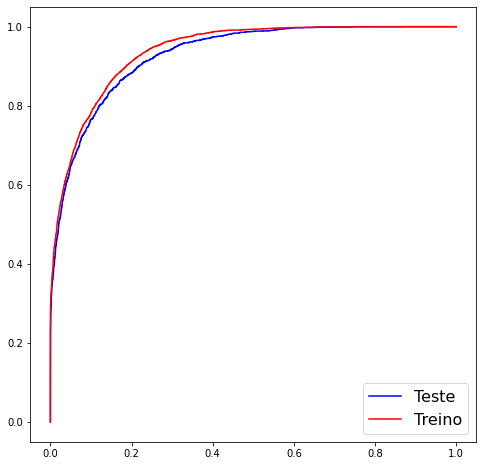

In [ ]:
plt.figure(figsize=(8,8))

fpr,tpr,ths = roc_curve(y_test,preds_2)
plt.plot(fpr,tpr,color='b', label='Teste')

fpr2,tpr2,ths2 = roc_curve(y_train,lgbm_2.predict_proba(X_train_d_2)[:,1])
plt.plot(fpr2,tpr2,color='r', label='Treino')

plt.legend(fontsize=16)

In [ ]:
imps = lgbm_2.best_estimator_.feature_importances_
cols = X_train_d_2.columns
order= np.argsort(imps)[::-1]

for col,imp in zip(cols[order],imps[order]):
    print(f'{col:30s} {imp:.2f}')

capital_gain                   223.00
age                            181.00
hours_per_week                 156.00
education_num                  129.00
capital_loss                   125.00
marital_status_ Married-civ-spouse 38.00
relationship_ Wife             29.00
sex_ Male                      26.00
occupation_ Prof-specialty     23.00
workclass_ Local-gov           21.00
relationship_ Not-in-family    20.00
relationship_ Unmarried        18.00
workclass_ Self-emp-not-inc    18.00
occupation_ Exec-managerial    17.00
workclass_ Private             17.00
workclass_ Federal-gov         13.00
occupation_ Farming-fishing    13.00
marital_status_ Never-married  12.00
occupation_ Other-service      12.00
occupation_ Sales              12.00
occupation_ Tech-support       12.00
occupation_ Transport-moving   12.00
race_ White                    12.00
workclass_ Self-emp-inc        11.00
occupation_ Protective-serv    11.00
occupation_ Priv-house-serv    10.00
relationship_ Own-child      



*   A curva de teste se aproximou da de treino comparado com o primeiro modelo



# Seleção e preparação de variáveis 3

In [ ]:
X_train_d_2

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_não_eua
9476,19,10,0,0,40,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
16917,37,14,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
31077,18,10,2176,0,20,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
14943,35,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2658,26,15,0,0,60,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,62,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
12077,25,9,0,0,40,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
15277,44,10,5178,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4517,61,9,0,0,45,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
X_train_d_3= X_train_d_2
X_test_d_3= X_test_d_2

In [ ]:
def auxiliar2(x):
    if x == 0:
        return 0
    else:
        return 1

X_train_d_3['capital_gain'] = X_train_2['capital_gain'].apply(auxiliar2)
X_test_d_3['capital_gain'] = X_test_2['capital_gain'].apply(auxiliar2)

X_train_d_3['capital_loss'] = X_train_2['capital_loss'].apply(auxiliar2)
X_test_d_3['capital_loss'] = X_test_2['capital_loss'].apply(auxiliar2)
X_train_d_3.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_não_eua
9476,19,10,0,0,40,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
16917,37,14,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
31077,18,10,1,0,20,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
14943,35,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2658,26,15,0,0,60,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [ ]:
X_train_d_3['capital_gain'].unique()

array([0, 1])

In [ ]:
X_train_d_3['capital_loss'].unique()

array([0, 1])

In [ ]:
# Configuração da Validação
kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)


params = {
    'max_depth': [3,5,7,9,11],
    'n_estimators':[50,100,150,200],
    'learning_rate': [0.05,0.1,0.2],
    'reg_alpha': [0,0.1,0.5],
    'reg_lambda': [0,0.1,0.5],
}
modelo=LGBMClassifier()
lgbm_3=RandomizedSearchCV(modelo, param_distributions = params,
                                   scoring = 'roc_auc', 
                                   cv = kf, 
                                   verbose = 1,
                                   n_iter = 10,
                                   n_jobs = -1)
lgbm_3.fit(X_train_d_3,y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=None),
                   estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [50, 100, 150, 200],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5]},
                   scoring='roc_auc', verbose=1)

In [ ]:
lgbm_3.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 150,
 'reg_alpha': 0,
 'reg_lambda': 0.1}

In [ ]:
preds_3 = lgbm_3.predict_proba(X_test_d_3)[:,1]
roc_auc_score(y_test,preds_3)

0.9064995148494878

In [ ]:
roc_auc_score(y_test,preds_3)

0.9064995148494878



*   O score foi de 0,9064, foi o pior, o valor do capital ganho ou perdido tem importância na predição.



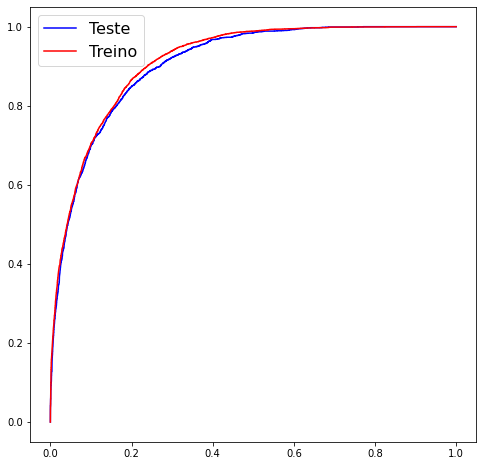

In [ ]:
plt.figure(figsize=(8,8))

fpr,tpr,ths = roc_curve(y_test,preds_3)
plt.plot(fpr,tpr,color='b', label='Teste')

fpr2,tpr2,ths2 = roc_curve(y_train,lgbm_3.predict_proba(X_train_d_3)[:,1])
plt.plot(fpr2,tpr2,color='r', label='Treino')

plt.legend(fontsize=16)

# Modelo final e predição na base de teste

In [ ]:
df_teste = pd.read_csv("/content/wage_test.csv")
df_teste

,Unnamed: 0,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
1,1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
2,2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
3,3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States
4,4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,16275,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
16276,16276,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States
16277,16277,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
16278,16278,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [ ]:
df_teste.drop(['Unnamed: 0','fnlwgt','education'], axis = 1, inplace = True)

In [ ]:
df_teste['native_country'] = df_teste['native_country'].apply(auxiliar)


In [ ]:
variaveis_cat = ['workclass', 'marital_status', 'occupation', 'relationship','race','sex','native_country']
df_teste = pd.get_dummies(df_teste,columns=variaveis_cat, drop_first=True)


In [ ]:
df_teste

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_não_eua
0,38,9,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,28,12,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,44,10,7688,0,40,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,18,10,0,0,30,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,34,6,0,0,30,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,39,13,0,0,36,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
16276,64,9,0,0,40,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
16277,38,13,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
16278,44,13,5455,0,40,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0


In [ ]:
preds_final = lgbm_2.predict(df_teste)

In [ ]:
preds_final

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
subm = pd.DataFrame()
subm['predictedValues'] = preds_final

In [ ]:
subm

,predictedValues
0,0
1,1
2,1
3,0
4,0
...,...
16275,0
16276,0
16277,1
16278,1


In [ ]:
subm['predictedValues']= subm['predictedValues'].map({0:'<=50K', 1:'>50K'})
subm.head()

,predictedValues
0,<=50K
1,>50K
2,>50K
3,<=50K
4,<=50K


In [ ]:
subm['predictedValues'].value_counts()/subm['predictedValues'].shape[0]

<=50K    0.798587
>50K     0.201413
Name: predictedValues, dtype: float64

In [ ]:
df['yearly_wage'] = df['yearly_wage'].map({' <=50K':0, ' >50K':1})
df.head()

In [ ]:
subm.to_csv('predicted.csv', index = False)